In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve
import pandas as pd

In [ ]:
np.random.seed(42)

# define the deterministic function (two function with two different omega)

def f1(x): return np.sin(x) # omega = 1

def f2(x): return np.cos(2 * x) # omega = 2

# the true mixing matrix
A = np.array([[1.0, -0.5],
              [0.8, 0.7]])

# random select 60 input points from range 0-10
X_train = np.sort(np.random.choice(np.linspace(0, 2*np.pi, 200), size=30, replace=False)).reshape(-1, 1) #sampling data nad reshape to columns

# select 40 points in [0,15] not overlap with training point
X_pool = np.linspace(0.01, 4*np.pi, 400)
X_test_candidates = np.setdiff1d(np.round(X_pool, 4), np.round(X_train.flatten(), 4))
X_test = np.sort(np.random.choice(X_test_candidates, size=200, replace=False)).reshape(-1, 1)

In [ ]:
a = np.linspace(0, 2*np.pi, 200)

In [ ]:
b = np.linspace(0.01, 4*np.pi, 400)

In [ ]:
c = set(a) & set(b)
c

set()

In [ ]:
# get latent functions value
f1_train = f1(X_train).flatten()
f2_train = f2(X_train).flatten()
f1_test = f1(X_test).flatten()
f2_test = f2(X_test).flatten()

In [ ]:
f1_train

array([ 0.45609916,  0.4839656 ,  0.8117917 ,  0.98877473,  0.98059231,
        0.94808684,  0.88630108,  0.87123964,  0.85530974,  0.83852724,
        0.82090888,  0.62788797,  0.52485216,  0.47009096,  0.20379202,
        0.14160452, -0.47009096, -0.69868515, -0.72092198, -0.78323563,
       -0.85530974, -0.99922127, -0.99623282, -0.96207936, -0.87887988,
       -0.79295273, -0.70989202, -0.64009622, -0.51134962, -0.39903056])

In [ ]:
f2_train

array([ 0.58394711,  0.53155459, -0.31801154, -0.95535095, -0.92312256,
       -0.79773733, -0.57105921, -0.51811703, -0.46310949, -0.40625585,
       -0.34778276,  0.21151339,  0.44906041,  0.55802898,  0.91693763,
        0.95989632,  0.55802898,  0.02367813, -0.039457  , -0.22691611,
       -0.46310949, -0.99688629, -0.98495967, -0.8511934 , -0.54485968,
       -0.25754807, -0.00789337,  0.18055365,  0.47704314,  0.68154923])

In [ ]:
# define true mixing amtrix A

A_true = np.array([[1.0, -0.5],
                   [0.8, 0.7]])

# noise
sigma1, sigma2 = 0.1, 0.1 # training data point noise

In [ ]:
# generate the output / ground truth

#train output + noise
y1_train = A_true[0, 0] * f1_train + A_true[0, 1] * f2_train + np.random.normal(0, sigma1, size=f1_train.shape)
y2_train = A_true[1, 0] * f1_train + A_true[1, 1] * f2_train + np.random.normal(0, sigma2, size=f2_train.shape)

#test output
y1_test = A_true[0, 0] * f1_test + A_true[0, 1] * f2_test
y2_test = A_true[1, 0] * f1_test + A_true[1, 1] * f2_test

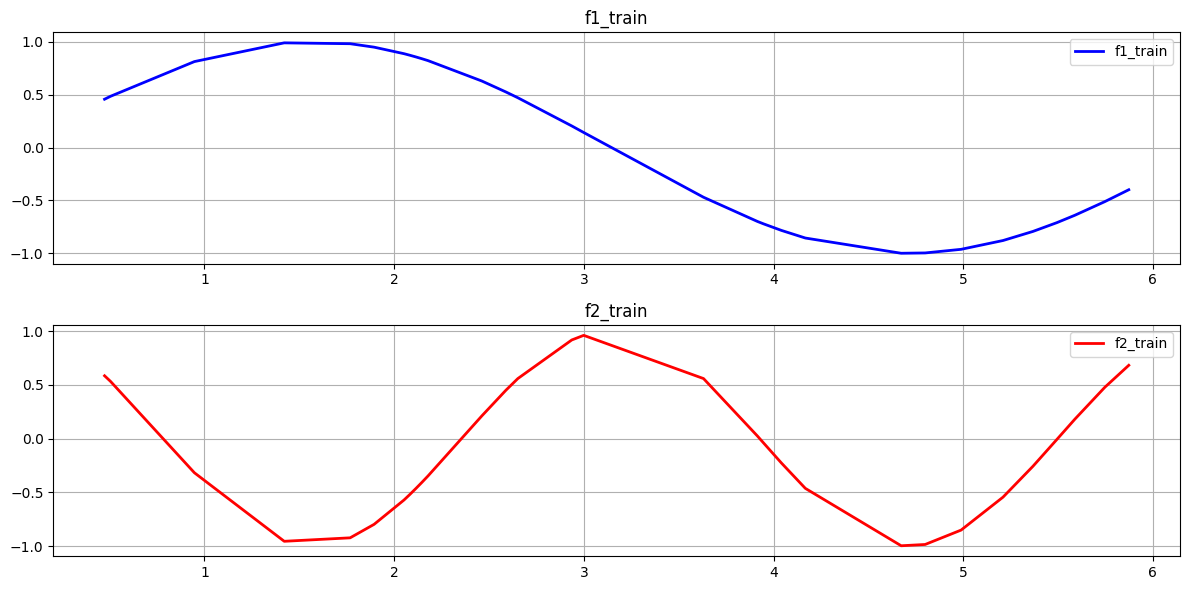

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(2,1,1)
plt.title("f1_train")
plt.plot(X_train, f1_train, color='blue', label='f1_train', linewidth=2)
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.title("f2_train")
plt.plot(X_train, f2_train, color='red', label='f2_train', linewidth=2)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

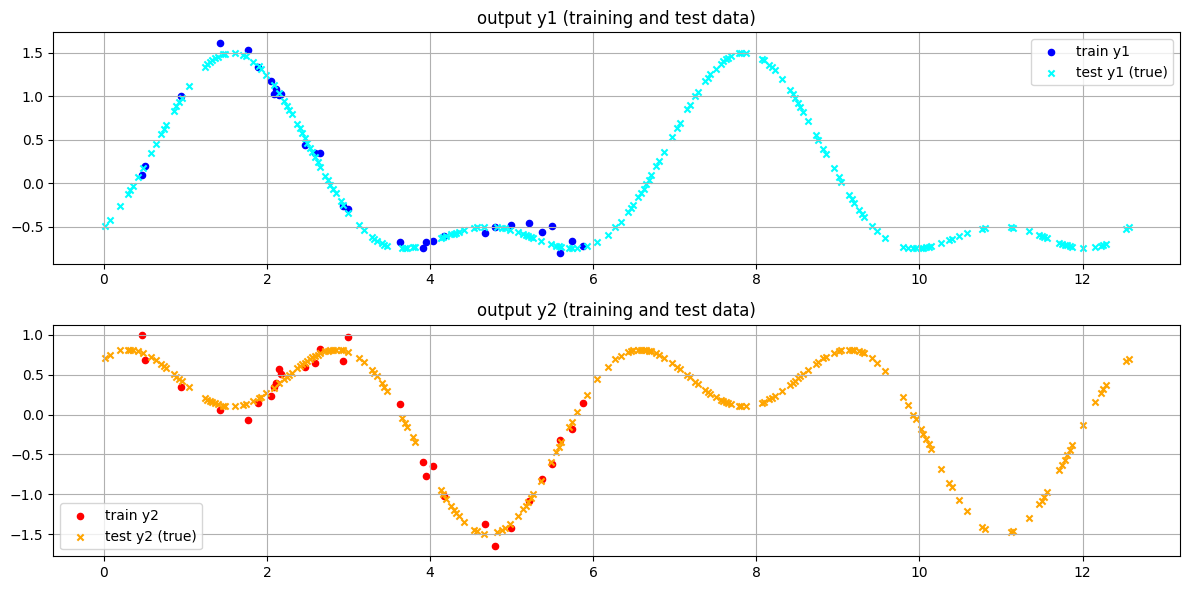

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title("output y1 (training and test data)")
plt.scatter(X_train, y1_train, color='blue', label='train y1', s=20)
plt.scatter(X_test, y1_test, color='cyan', label='test y1 (true)', s=20, marker='x')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("output y2 (training and test data)")
plt.scatter(X_train, y2_train, color='red', label='train y2', s=20)
plt.scatter(X_test, y2_test, color='orange', label='test y2 (true)', s=20, marker='x')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
train_data = {
    'X': X_train,
    'y1': y1_train,
    'y2': y2_train,
    'f1': f1_train,
    'f2': f2_train
}

test_data = {
    'X': X_test,
    'y1': y1_test,
    'y2': y2_test,
    'f1': f1_test,
    'f2': f2_test
}

A_true, train_data, test_data

Y_train = np.vstack([y1_train.reshape(-1, 1), y2_train.reshape(-1, 1)])
Y_train.shape

(60, 1)

In [ ]:
## define the kernel function using int the SLFM model
## there are two kernel function will be use - RBF and Periodic

def rbf_kernel(X1, X2, lengthscale, variance):
    X1 = np.atleast_2d(X1) # view the array input X as an matrix 2d
    X2 = np.atleast_2d(X2)

    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 * sqdist / lengthscale**2)

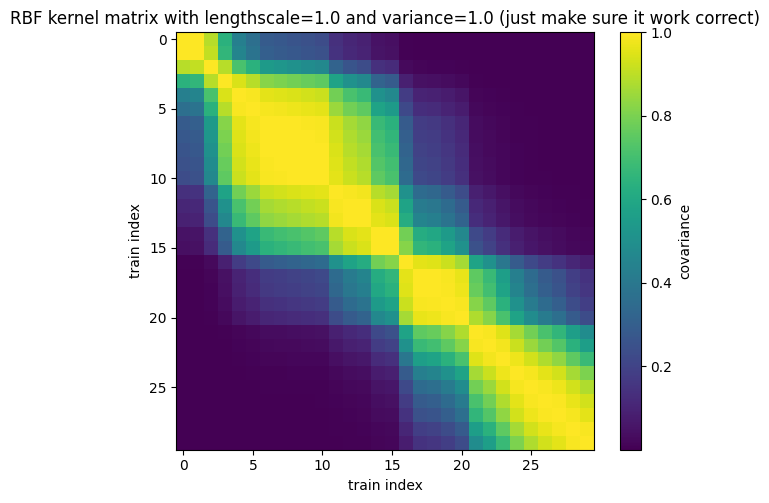

In [ ]:
# plot test RBF kernel matrix
K_rbf = rbf_kernel(X_train, X_train, lengthscale=1.0, variance=1.0)

plt.figure(figsize=(6, 5))
plt.imshow(K_rbf, cmap='viridis')
plt.colorbar(label='covariance')
plt.title(f"RBF kernel matrix with lengthscale=1.0 and variance=1.0 (just make sure it work correct)")
plt.xlabel("train index")
plt.ylabel("train index")
plt.tight_layout()
plt.show()

In [ ]:
# define the SLFM kernel with 2 latent function -> 2 latent kernel

# K_slfm = sum(a_q * a_qT kronecker K_q(X,X))

def compute_slfm_covariance_from_Kq(K_q_list, A):

    S, Q = A.shape
    N = K_q_list[0].shape[0]
    cov = np.zeros((S * N, S * N))

    for q in range(Q):
        aq = A[:, q].reshape(S, 1)  # (S, 1)
        Bq = aq @ aq.T              # (S, S)
        cov += np.kron(Bq, K_q_list[q])  # (S*N, S*N)

    return cov

def compute_slfm_covariance_rbf(X, A, kernel_params):
    K_q_list = [
        rbf_kernel(X, X, lengthscale=kp['lengthscale'], variance=kp['variance'])
        for kp in kernel_params
    ]
    return compute_slfm_covariance_from_Kq(K_q_list, A)


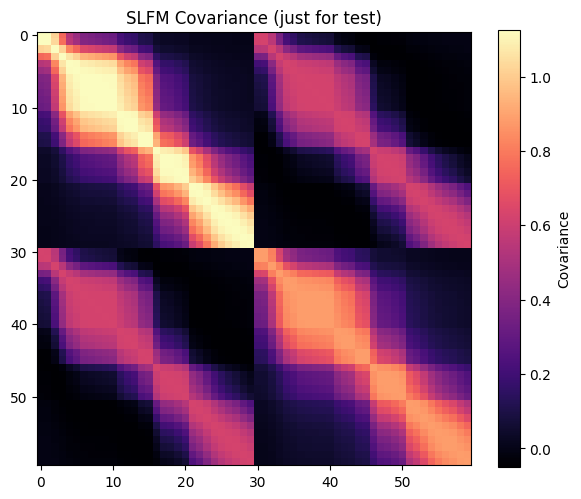

In [ ]:
K_q_test = [
    rbf_kernel(X_train, X_train, lengthscale=1.0, variance=1.0),
    rbf_kernel(X_train, X_train, lengthscale=2.0, variance=0.5),
]
A_test = np.array([[1.0, -0.5], [0.8, 0.7]])
K_slfm_modular = compute_slfm_covariance_from_Kq(K_q_test, A_test)

plt.figure(figsize=(6, 5))
plt.imshow(K_slfm_modular, cmap='magma')
plt.title("SLFM Covariance (just for test)")
plt.colorbar(label='Covariance')
plt.tight_layout()
plt.show()

In [ ]:
# now we already define the kernel matrix for the prior => training
# by definining the marginal likelihood based on this function for learn the K_1q hyperparams and A matrix

def negative_log_marginal_likelihood_modular(params, X, Y, Q, S):
    N = X.shape[0] # number of samples

    #params index: kernel -> noise -> mixing matrix
    offset = 2 * Q # number of kernel params
    offset_noise = offset + S # index of noise params
    total_params = offset_noise + S * Q

    # kernel - getting aprpropriate kernel params
    kernel_params = []
    for q in range(Q):
        ell = np.exp(params[2 * q])
        var = np.exp(params[2 * q + 1])
        kernel_params.append({'lengthscale': ell, 'variance': var})

    # noise
    noises = [np.exp(params[offset + i]) for i in range(S)] # getting noise value (variance)

    # mixing matrix A
    A_flat = params[offset_noise:total_params] ## getting the initial params
    A = A_flat.reshape(S, Q) ## reshape vector into matrix of the mixing matrix

    # compute K_q for each latent function - with appropriate params
    K_q_list = [
        rbf_kernel(X, X, lengthscale=kp['lengthscale'], variance=kp['variance'])
        for kp in kernel_params
    ]

    # SLFM covariance
    K_slfm = compute_slfm_covariance_from_Kq(K_q_list, A)

    # add noise
    Sigma = np.zeros((S * N, S * N))
    for i in range(S):
    ## add noise for appropriate output (only diagnonal since no correlation noise btw output)
        Sigma[i * N:(i + 1) * N, i * N:(i + 1) * N] = noises[i]**2 * np.eye(N)

    Ky = K_slfm + Sigma + 1e-6 * np.eye(S * N) ## adding the stable jitter when compute

    # Cholesky trick
    try:
        L, lower = cho_factor(Ky)
        alpha = cho_solve((L, lower), Y)
        lml = -0.5 * np.dot(Y.ravel(), alpha.ravel()) - np.sum(np.log(np.diag(L))) - (S * N / 2) * np.log(2 * np.pi)
        return -lml
    except np.linalg.LinAlgError:
        return 1e6


In [ ]:
Q = 2 # 2 latent function
S = 2 # 2 output

init_kernel_params = [np.log(0.5), np.log(0.5)] * Q  # 2*Q values (lengthscale and variance per latent)
init_noise_params = [np.log(0.1)] * S                # log noise std for each output
init_A_params = list(np.random.randn(S * Q))         # S*Q values (raw A entries, can be negative)

init_params = np.array(init_kernel_params + init_noise_params + init_A_params)


In [ ]:
# Optimization
res_rbf = minimize(negative_log_marginal_likelihood_modular,
               x0=init_params,
               args=(X_train, Y_train, Q, S),
               method='L-BFGS-B',
               options={'maxiter': 300, 'disp': True})

In [ ]:
# Extract optimized parameters
# kernel hyperparams after optimize

opt_params = res_rbf.x

opt_kernel_params = [{'lengthscale': np.exp(opt_params[2 * q]),
                      'variance': np.exp(opt_params[2 * q + 1])} for q in range(Q)]
print("Kernel hyper params after optimize the model: \n", opt_kernel_params)


opt_noises = [np.exp(opt_params[2 * Q + i]) for i in range(S)]
print("Noise params after optimize the model: \n", opt_noises)

opt_A = opt_params[2 * Q + S:].reshape(S, Q)
print("Mixing matrix params after optimize the model: \n", opt_A)
# (opt_kernel_params, opt_noises, opt_A)

Kernel hyper params after optimize the model: 
 [{'lengthscale': 1.6850556626801705, 'variance': 0.6389594333161416}, {'lengthscale': 0.7187355210190276, 'variance': 0.4417243157526323}]
Noise params after optimize the model: 
 [0.06739765234686439, 0.11667537485798267]
Mixing matrix params after optimize the model: 
 [[ 1.12872242  0.62324128]
 [ 0.77636217 -0.96507787]]


In [ ]:
## get the log maginal likelihood of the rbf kernel
lml_rbf = -res_rbf.fun
lml_rbf

23.734404274756223

In [ ]:
# Correct predictive covariance by computing full test covariance K_test
def slfm_full_test_covariance(Kq_test, A):
    Q = len(Kq_test)
    S = A.shape[0]
    N_test = Kq_test[0].shape[0]

    K = np.zeros((S * N_test, S * N_test))
    for q in range(Q):
        Aq = A[:, q].reshape(S, 1)
        K += np.kron(Aq @ Aq.T, Kq_test[q])
    return K

In [ ]:
def slfm_predict_corrected(X_train, Y_train, X_test, opt_kernel_params, opt_A, opt_noises):
    Q = len(opt_kernel_params)
    S = opt_A.shape[0]
    N_train = X_train.shape[0]
    N_test = X_test.shape[0]

    # calculate Kq(X_train, X_train) and Kq(X_test, X_train) and Kq(X_test, X_test)
    Kq_train = [
        rbf_kernel(X_train, X_train, lengthscale=p['lengthscale'], variance=p['variance'])
        for p in opt_kernel_params
    ]
    Kq_cross = [
        rbf_kernel(X_test, X_train, lengthscale=p['lengthscale'], variance=p['variance'])
        for p in opt_kernel_params
    ]
    Kq_test = [
        rbf_kernel(X_test, X_test, lengthscale=p['lengthscale'], variance=p['variance'])
        for p in opt_kernel_params
    ]

    # full SLFM covariance matrices
    K_train = compute_slfm_covariance_from_Kq(Kq_train, opt_A) # optimized SLFM kernel using training data


    K_cross = np.zeros((S * N_test, S * N_train))
    for q in range(Q):
        Aq = opt_A[:, q].reshape(S, 1)
        K_cross += np.kron(Aq @ opt_A[:, q].reshape(1, S), Kq_cross[q])

    # add noise to train covariance
    for i in range(S):
        K_train[i*N_train:(i+1)*N_train, i*N_train:(i+1)*N_train] += opt_noises[i]**2 * np.eye(N_train)

    # prediction mean
    L, lower = cho_factor(K_train + 1e-6 * np.eye(S * N_train))
    alpha = cho_solve((L, lower), Y_train)
    mu_pred = K_cross @ alpha  # shape: (S * N_test, 1)

    # predicton covariance
    K_test_full = slfm_full_test_covariance(Kq_test, opt_A)
    v = cho_solve((L, lower), K_cross.T)
    cov_pred = np.diag(K_test_full) - np.sum(K_cross * v.T, axis=1)
    std_pred = np.sqrt(np.clip(cov_pred, 1e-10, None))  # numerical safety

    return mu_pred.reshape(S, N_test), std_pred.reshape(S, N_test)

# prediction
mu_pred_fixed, std_pred_fixed = slfm_predict_corrected(X_train, Y_train, X_test, opt_kernel_params, opt_A, opt_noises)

mu_pred_fixed, std_pred_fixed

(array([[-4.41863777e-01, -3.88404822e-01, -2.58935300e-01,
         -1.41336758e-01, -9.81777696e-02, -5.31036192e-02,
          4.24262936e-02,  1.44829818e-01,  3.09786108e-01,
          4.25375438e-01,  5.44018750e-01,  6.04095238e-01,
          6.64330082e-01,  8.43523017e-01,  9.01903353e-01,
          9.59451840e-01,  1.01573617e+00,  1.17442803e+00,
          1.42694979e+00,  1.45844824e+00,  1.48651533e+00,
          1.51097561e+00,  1.53190304e+00,  1.54915376e+00,
          1.57246901e+00,  1.57856014e+00,  1.56657541e+00,
          1.52171633e+00,  1.50063335e+00,  1.42078411e+00,
          1.35537545e+00,  1.31964908e+00,  1.24251298e+00,
          1.11559560e+00,  1.02509554e+00,  9.30811556e-01,
          8.82713011e-01,  8.33841323e-01,  7.84429282e-01,
          6.84437219e-01,  6.33832982e-01,  5.82960701e-01,
          5.32044579e-01,  4.80822020e-01,  4.29518105e-01,
          3.78361466e-01,  3.27095432e-01,  2.75956771e-01,
          2.25185814e-01,  1.24283317e-0

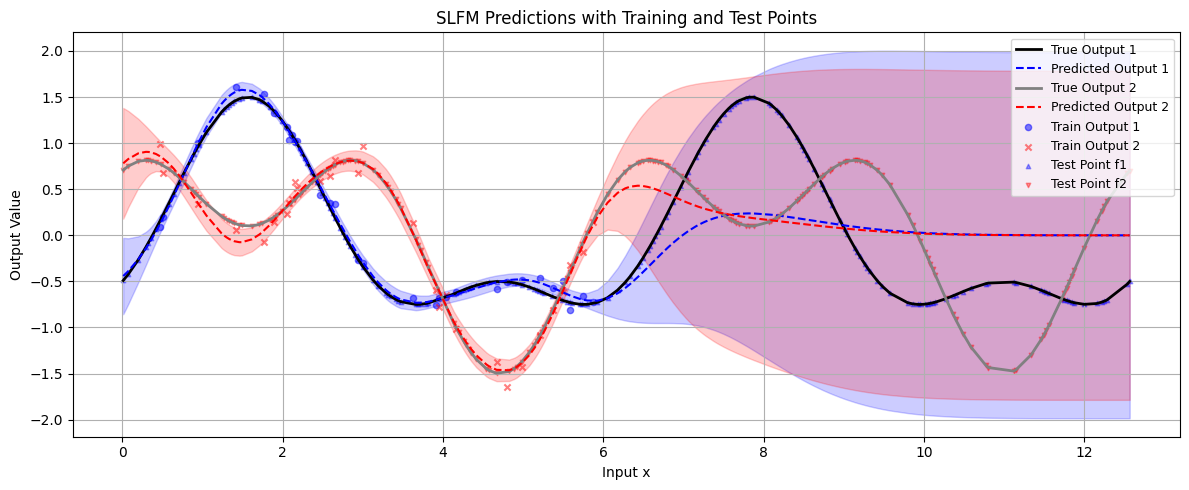

In [ ]:
# Plot predictions and uncertainties with training and test points highlighted
fig, ax = plt.subplots(figsize=(12, 5))

# Training and test inputs
X_train_flat = X_train.flatten()
X_test_flat = X_test.flatten()

# Plot true and predicted for Output 1
ax.plot(X_test, y1_test, label="True Output 1", color="black", linewidth=2)
ax.plot(X_test, mu_pred_fixed[0], label="Predicted Output 1", linestyle="--", color="blue")
ax.fill_between(X_test_flat,
                mu_pred_fixed[0] - 2 * std_pred_fixed[0],
                mu_pred_fixed[0] + 2 * std_pred_fixed[0],
                color="blue", alpha=0.2)

# Plot true and predicted for Output 2
ax.plot(X_test, y2_test, label="True Output 2", color="gray", linewidth=2)
ax.plot(X_test, mu_pred_fixed[1], label="Predicted Output 2", linestyle="--", color="red")
ax.fill_between(X_test_flat,
                mu_pred_fixed[1] - 2 * std_pred_fixed[1],
                mu_pred_fixed[1] + 2 * std_pred_fixed[1],
                color="red", alpha=0.2)

# Scatter training points
ax.scatter(X_train, y1_train, color="blue", s=20, label="Train Output 1", alpha=0.5, marker='o')
ax.scatter(X_train, y2_train, color="red", s=20, label="Train Output 2", alpha=0.5, marker='x')

# Scatter test points (without noise)
ax.scatter(X_test, y1_test, color="blue", s=10, label="Test Point f1", alpha=0.4, marker='^')
ax.scatter(X_test, y2_test, color="red", s=10, label="Test Point f2", alpha=0.4, marker='v')

# Plot settings
ax.set_title("SLFM Predictions with Training and Test Points")
ax.set_xlabel("Input x")
ax.set_ylabel("Output Value")
ax.legend(loc="upper right", fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()


# PERIODIDC KERNEL

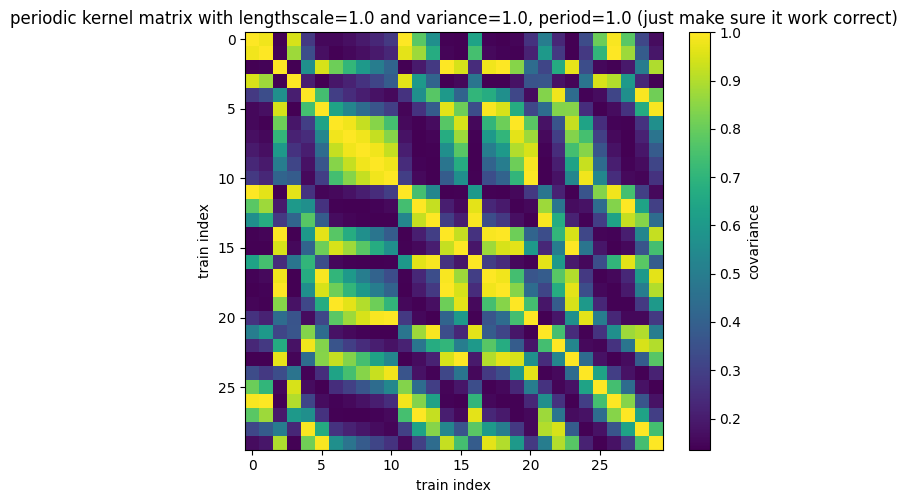

In [ ]:
## the result seems not good, we can try with the periodic kernel

def periodic_kernel(X1, X2, lengthscale, variance, period):
  X_1 = np.atleast_2d(X1).reshape(-1, 1)
  X_2 = np.atleast_2d(X2).reshape(-1, 1)
  dists = np.abs(X1 - X2.T)
  sin_term = np.sin(np.pi * dists / period)
  return variance**2 * np.exp(-2 * (sin_term**2) / lengthscale**2)


# plot test periodic kernel matrix
K_period = periodic_kernel(X_train, X_train, lengthscale=1.0, variance=1.0, period=1.0)

plt.figure(figsize=(6, 5))
plt.imshow(K_period, cmap='viridis')
plt.colorbar(label='covariance')
plt.title(f"periodic kernel matrix with lengthscale=1.0 and variance=1.0, period=1.0 (just make sure it work correct)")
plt.xlabel("train index")
plt.ylabel("train index")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.linalg import cho_factor, cho_solve

def periodic_negative_log_marginal_likelihood_modular(params, X, Y, Q, S):
    N = X.shape[0]  # number of training points

    # parameter offsets
    offset_kernel = 3 * Q
    offset_noise = offset_kernel + S
    offset_total = offset_noise + S * Q

    # extract kernel hyperparameters
    kernel_params = []
    for q in range(Q):
        lengthscale = np.exp(params[3 * q])
        variance = np.exp(params[3 * q + 1])
        period = np.exp(params[3 * q + 2])
        kernel_params.append({'lengthscale': lengthscale, 'variance': variance, 'period': period})

    # extract noise variances for each output
    noise_vars = [np.exp(params[offset_kernel + i]) for i in range(S)]

    # extract mixing matrix A
    A_flat = params[offset_noise:offset_total]
    A = A_flat.reshape(S, Q)

    # build kernel matrices for each latent function
    K_q_list = [
        periodic_kernel(X, X,
                        lengthscale=kp['lengthscale'],
                        variance=kp['variance'],
                        period=kp['period'])
        for kp in kernel_params
    ]

    # SLFM full covariance matrix
    K_slfm = compute_slfm_covariance_from_Kq(K_q_list, A)

    # add noise to the diagonal blocks
    Sigma = np.zeros((S * N, S * N))
    for i in range(S):
        idx = slice(i * N, (i + 1) * N)
        Sigma[idx, idx] = noise_vars[i]**2 * np.eye(N)

    Ky = K_slfm + Sigma + 1e-6 * np.eye(S * N)  # add jitter for numerical stability

    # compute negative log marginal likelihood using Cholesky decomposition
    try:
        L, lower = cho_factor(Ky)
        alpha = cho_solve((L, lower), Y)
        lml = -0.5 * np.dot(Y.ravel(), alpha.ravel()) - np.sum(np.log(np.diag(L))) - (S * N / 2) * np.log(2 * np.pi)
        return -lml  # return the negative of log marginal likelihood
    except np.linalg.LinAlgError:
        return 1e6  # return large penalty if Ky is not positive definite

In [ ]:
Q , S = 2, 2
N = X_train.shape[0]

# Initial parameters
init_kernel_params = np.log([
    2, 2, 1 * np.pi,   # latent function 1
    2, 2, 1 * np.pi    # latent function 2
])   # 3 per random start kernel hypaperparamers per latent
init_noise_params = np.log([0.1] * S)
init_A_params = np.random.randn(S * Q) * 0.1

init_params = np.concatenate([init_kernel_params, init_noise_params, init_A_params])

In [ ]:
# optimization
res_period = minimize(periodic_negative_log_marginal_likelihood_modular,
               x0=init_params,
               args=(X_train, Y_train, Q, S),
               method='L-BFGS-B',
               options={'maxiter': 300, 'disp': True})

In [ ]:
opt_params = res_period.x

# Decode kernel, noise, and A from optimized vector
opt_kernel_params = [
    {
        'lengthscale': np.exp(opt_params[3*q]),
        'variance':    np.exp(opt_params[3*q + 1]),
        'period':      np.exp(opt_params[3*q + 2])
    }
    for q in range(Q)
]

print("Optimal value for hyperparameter using periodic kernel:\n", opt_kernel_params)

opt_noises = [np.exp(opt_params[3*Q + i]) for i in range(S)]
print("Optimal noise variance for periodic kernel:\n", opt_noises)

opt_A = opt_params[3*Q + S:].reshape(S, Q)
print("Trainable matrix A for periodic kernel:\n", opt_A)


Optimal value for hyperparameter using periodic kernel:
 [{'lengthscale': 12.951321344119098, 'variance': 4.219019101620522, 'period': 6.237385107444863}, {'lengthscale': 5.344156641189556, 'variance': 1.7691082473670057, 'period': 3.173548215758924}]
Optimal noise variance for periodic kernel:
 [0.07644551164657674, 0.11061827731613143]
Trainable matrix A for periodic kernel:
 [[-1.53175228  0.7848354 ]
 [-1.21842661 -1.1546191 ]]


In [ ]:
## get log maginal likelihood
lml_period = -res_period.fun
lml_period

32.56634422297616

In [ ]:
def slfm_predict_corrected(X_train, Y_train, X_test, opt_kernel_params, opt_A, opt_noises):
    Q = len(opt_kernel_params)
    S = opt_A.shape[0]
    N_train = X_train.shape[0]
    N_test = X_test.shape[0]

    # calculate Kq(X_train, X_train) and Kq(X_test, X_train) and Kq(X_test, X_test)
    Kq_train = [
        periodic_kernel(X_train, X_train, lengthscale=p['lengthscale'], variance=p['variance'], period=p['period'])
        for p in opt_kernel_params
    ]
    Kq_cross = [
        periodic_kernel(X_test, X_train, lengthscale=p['lengthscale'], variance=p['variance'], period=p['period'])
        for p in opt_kernel_params
    ]
    Kq_test = [
        periodic_kernel(X_test, X_test, lengthscale=p['lengthscale'], variance=p['variance'], period=p['period'])
        for p in opt_kernel_params
    ]

    # full SLFM covariance matrices
    K_train = compute_slfm_covariance_from_Kq(Kq_train, opt_A) # optimized SLFM kernel using training data


    K_cross = np.zeros((S * N_test, S * N_train))
    for q in range(Q):
        Aq = opt_A[:, q].reshape(S, 1)
        K_cross += np.kron(Aq @ opt_A[:, q].reshape(1, S), Kq_cross[q])

    # add noise to train covariance
    for i in range(S):
        K_train[i*N_train:(i+1)*N_train, i*N_train:(i+1)*N_train] += opt_noises[i]**2 * np.eye(N_train)

    # prediction mean
    L, lower = cho_factor(K_train + 1e-6 * np.eye(S * N_train))
    alpha = cho_solve((L, lower), Y_train)
    mu_pred = K_cross @ alpha  # shape: (S * N_test, 1)

    # predicton covariance
    K_test_full = slfm_full_test_covariance(Kq_test, opt_A)
    v = cho_solve((L, lower), K_cross.T)
    cov_pred = np.diag(K_test_full) - np.sum(K_cross * v.T, axis=1)
    std_pred = np.sqrt(np.clip(cov_pred, 1e-10, None))  # numerical safety

    return mu_pred.reshape(S, N_test), std_pred.reshape(S, N_test)

# prediction
mu_pred_fixed_period, std_pred_fixed_period = slfm_predict_corrected(X_train, Y_train, X_test, opt_kernel_params, opt_A, opt_noises)

mu_pred_fixed_period, std_pred_fixed_period

(array([[-0.50095282, -0.4337289 , -0.27638445, -0.13985621, -0.09111616,
         -0.04092943,  0.0632007 ,  0.17177572,  0.34093559,  0.45582449,
          0.57105331,  0.62846618,  0.68545359,  0.85195083,  0.9053346 ,
          0.95760311,  1.0084187 ,  1.15041861,  1.37549746,  1.4040203 ,
          1.42971304,  1.45243826,  1.47228202,  1.48911943,  1.5136098 ,
          1.52126116,  1.52114618,  1.48953626,  1.47330002,  1.40824617,
          1.35212274,  1.32063571,  1.25093068,  1.13182567,  1.04404282,
          0.95046994,  0.90201683,  0.85235471,  0.80175501,  0.69838253,
          0.6456801 ,  0.59250982,  0.53915789,  0.48539931,  0.43151794,
          0.37779853,  0.32401172,  0.27044108,  0.21736679,  0.11230536,
          0.06070756,  0.01003667, -0.03992313, -0.08890335, -0.18336433,
         -0.22879378, -0.31527973, -0.46898361, -0.53483584, -0.61861182,
         -0.64237366, -0.66398973, -0.70068208, -0.71581489, -0.72879868,
         -0.76357086, -0.76272713, -0.

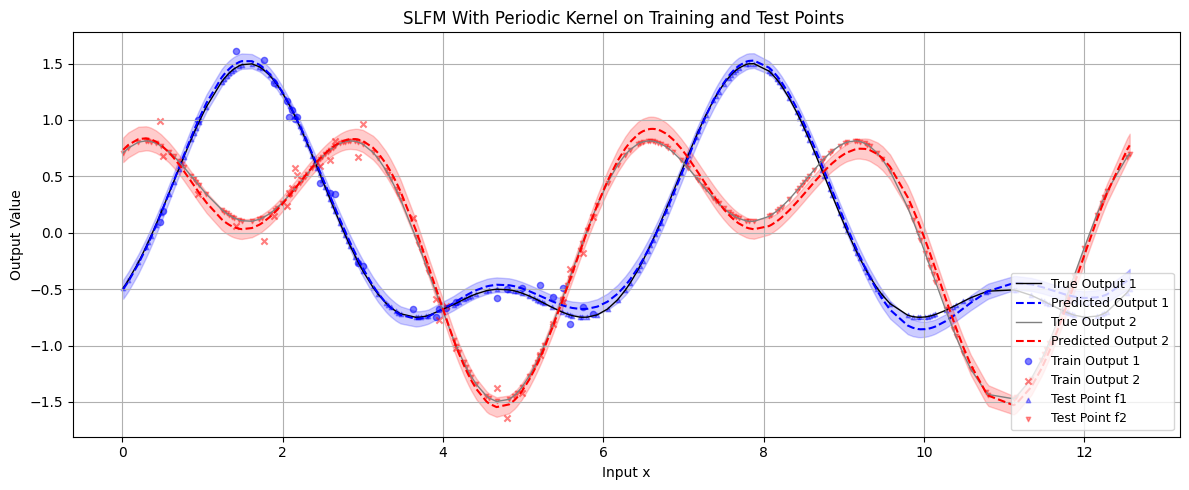

In [ ]:
# Plot predictions and uncertainties with training and test points highlighted
fig, ax = plt.subplots(figsize=(12, 5))

# Training and test inputs
X_train_flat = X_train.flatten()
X_test_flat = X_test.flatten()

# Plot true and predicted for Output 1
ax.plot(X_test, y1_test, label="True Output 1", color="black", linewidth=1)
ax.plot(X_test, mu_pred_fixed_period[0], label="Predicted Output 1", linestyle="--", color="blue")
ax.fill_between(X_test_flat,
                mu_pred_fixed_period[0] - 2 * std_pred_fixed_period[0],
                mu_pred_fixed_period[0] + 2 * std_pred_fixed_period[0],
                color="blue", alpha=0.2)

# Plot true and predicted for Output 2
ax.plot(X_test, y2_test, label="True Output 2", color="gray", linewidth=1)
ax.plot(X_test, mu_pred_fixed_period[1], label="Predicted Output 2", linestyle="--", color="red")
ax.fill_between(X_test_flat,
                mu_pred_fixed_period[1] - 2 * std_pred_fixed_period[1],
                mu_pred_fixed_period[1] + 2 * std_pred_fixed_period[1],
                color="red", alpha=0.2)

# Scatter training points
ax.scatter(X_train, y1_train, color="blue", s=20, label="Train Output 1", alpha=0.5, marker='o')
ax.scatter(X_train, y2_train, color="red", s=20, label="Train Output 2", alpha=0.5, marker='x')

# Scatter test points (without noise)
ax.scatter(X_test, y1_test, color="blue", s=10, label="Test Point f1", alpha=0.4, marker='^')
ax.scatter(X_test, y2_test, color="red", s=10, label="Test Point f2", alpha=0.4, marker='v')

# Plot settings
ax.set_title("SLFM With Periodic Kernel on Training and Test Points ")
ax.set_xlabel("Input x")
ax.set_ylabel("Output Value")
ax.legend(loc="lower right", fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()


## Compare result of two model

In [ ]:
from sklearn.metrics import mean_squared_error

y1_true = test_data["y1"]
y2_true = test_data["y2"]

In [ ]:
y1_true

array([-0.48990017, -0.42185955, -0.26350336, -0.12745196, -0.07919891,
       -0.02968236,  0.07253746,  0.17843292,  0.34221931,  0.45278177,
        0.56325897,  0.61818985,  0.67266063,  0.83167547,  0.8826799 ,
        0.93266055,  0.9813127 ,  1.117803  ,  1.33774642,  1.36628194,
        1.39223734,  1.41546642,  1.43604847,  1.45384437,  1.48084136,
        1.49000526,  1.49708372,  1.47132161,  1.45696025,  1.3969532 ,
        1.34346311,  1.31300822,  1.24473814,  1.12607601,  1.03744472,
        0.94217867,  0.89260398,  0.8416577 ,  0.78963817,  0.68313069,
        0.62876592,  0.57391253,  0.51889355,  0.46350503,  0.40806752,
        0.35290061,  0.29779469,  0.24306525,  0.18901999,  0.08264948,
        0.03075105, -0.01996818, -0.06971682, -0.11822241, -0.21095457,
       -0.25514113, -0.33845723, -0.48364909, -0.54460093, -0.62093121,
       -0.64231761, -0.66166683, -0.69427684, -0.70764202, -0.71907487,
       -0.74998345, -0.74947333, -0.7475463 , -0.73979001, -0.73

In [ ]:
#result of prediction using model trained by rbf kernel

y1_pred_rbf = mu_pred_fixed[0]
y2_pred_rbf = mu_pred_fixed[1]

#result of prediction using the model trained by the periodic kernel
y1_pred_period = mu_pred_fixed_period[0]
y2_pred_period = mu_pred_fixed_period[1]

In [ ]:
#calculate the MSE
mse_rbf = [mean_squared_error(y1_true, y1_pred_rbf), mean_squared_error(y2_true, y2_pred_rbf)]
mse_period = [mean_squared_error(y1_true, y1_pred_period), mean_squared_error(y2_true, y2_pred_period)]

In [ ]:
mse_rbf

[0.25751041780643996, 0.16482254939934826]

In [ ]:
mse_period

[0.003286593878991298, 0.004132276848281301]

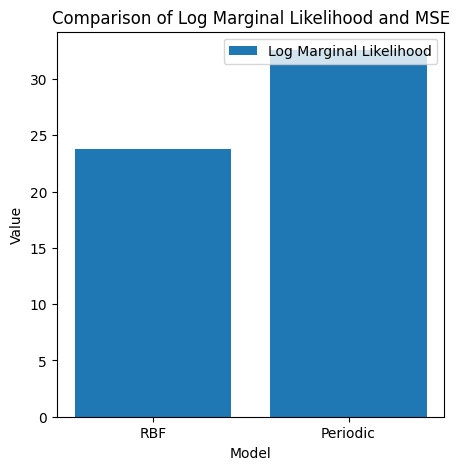

In [ ]:
#plot the lml and MSE for comparison

plt.figure(figsize=(5, 5))
plt.bar(['RBF', 'Periodic'], [lml_rbf, lml_period], label='Log Marginal Likelihood')
plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Comparison of Log Marginal Likelihood and MSE')
plt.legend()
plt.show()

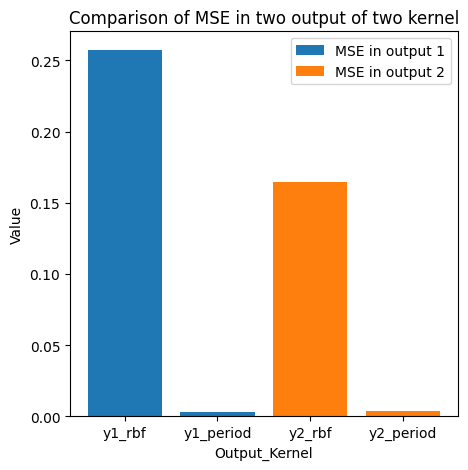

In [ ]:
plt.figure(figsize=(5, 5))
plt.bar(['y1_rbf', 'y1_period'], [mse_rbf[0], mse_period[0]], label='MSE in output 1')
plt.bar(['y2_rbf', 'y2_period'], [mse_rbf[1], mse_period[1]], label='MSE in output 2')
plt.xlabel('Output_Kernel')
plt.ylabel('Value')
plt.title('Comparison of MSE in two output of two kernel')
plt.legend()
plt.show()

## Using GPy to getting model for the MOGP

In [ ]:
# !pip install GPy

In [ ]:
import GPy

In [ ]:
X1 = X_train.copy()                          # (N, 1)
Y1 = y1_train.reshape(-1, 1)

X2 = X_train.copy()
Y2 = y2_train.reshape(-1, 1)

X_list = [X1, X2]
Y_list = [Y1, Y2]

In [ ]:
import GPy
from GPy.util.multioutput import LCM

# create a list of two independent periodic kernels
kern_list = [
    GPy.kern.StdPeriodic(1, variance=2.0, lengthscale=2.0, period=np.pi),
    GPy.kern.StdPeriodic(1, variance=2.0, lengthscale=2.0, period=np.pi)
]

for k in kern_list:
    k.variance.constrain_bounded(1e-3, 15.0)
    k.lengthscale.constrain_bounded(0.1, 5.0)
    k.period.constrain_bounded(0.5, 10.0)

# lcm 2 latent functions and 2 outputs
lcm_kernel = LCM(input_dim=1, num_outputs=2, kernels_list=kern_list)

In [ ]:
model = GPy.models.GPCoregionalizedRegression(X_list, Y_list, kernel=lcm_kernel)
model.optimize(messages=True)




In [ ]:
# Create test sets with index 0 and 1
Xtest_0 = np.hstack([X_test, np.zeros_like(X_test)])
Xtest_1 = np.hstack([X_test, np.ones_like(X_test)])

# Create metadata
Y_metadata_0 = {'output_index': np.zeros((X_test.shape[0], 1), dtype=int)}
Y_metadata_1 = {'output_index': np.ones((X_test.shape[0], 1), dtype=int)}

# Predict with metadata
mu_0, var_0 = model.predict(Xtest_0, Y_metadata=Y_metadata_0)
mu_1, var_1 = model.predict(Xtest_1, Y_metadata=Y_metadata_1)


In [ ]:
from sklearn.metrics import mean_squared_error

mse_0 = mean_squared_error(y1_test, mu_0)
mse_1 = mean_squared_error(y2_test, mu_1)
lml_lib = model.log_likelihood()


In [ ]:
print("MSE output 1:", mse_0)
print("MSE output 2:", mse_1)
print("Log Marginal Likelihood:", lml_lib)

MSE output 1: 0.0032060272029459246
MSE output 2: 0.00381134651378784
Log Marginal Likelihood: 32.33859918043801


In [ ]:
model.sum

sum.,value,constraints,priors
ICM0.std_periodic.variance,0.008172722525731578,"0.001,15.0",
ICM0.std_periodic.period,3.173573515300922,"0.5,10.0",
ICM0.std_periodic.lengthscale,4.999999999992845,"0.1,5.0",
ICM0.B.W,"(2, 1)",,
ICM0.B.kappa,"(2,)",+ve,
ICM1.std_periodic.variance,0.021611425162758956,"0.001,15.0",
ICM1.std_periodic.period,6.236566630411933,"0.5,10.0",
ICM1.std_periodic.lengthscale,4.99986173680051,"0.1,5.0",
ICM1.B.W,"(2, 1)",,
ICM1.B.kappa,"(2,)",+ve,


In [ ]:
A1 = model.sum.ICM0.B.W
A2 = model.sum.ICM1.B.W

In [ ]:
A1

gp.sum.ICM0.B.W:
Param([[ 30.7723889 ],
       [-45.18122097]])

In [ ]:
A2

gp.sum.ICM1.B.W:
Param([[33.0664421 ],
       [26.35808225]])

In [ ]:
mu_1.shape

(200, 1)

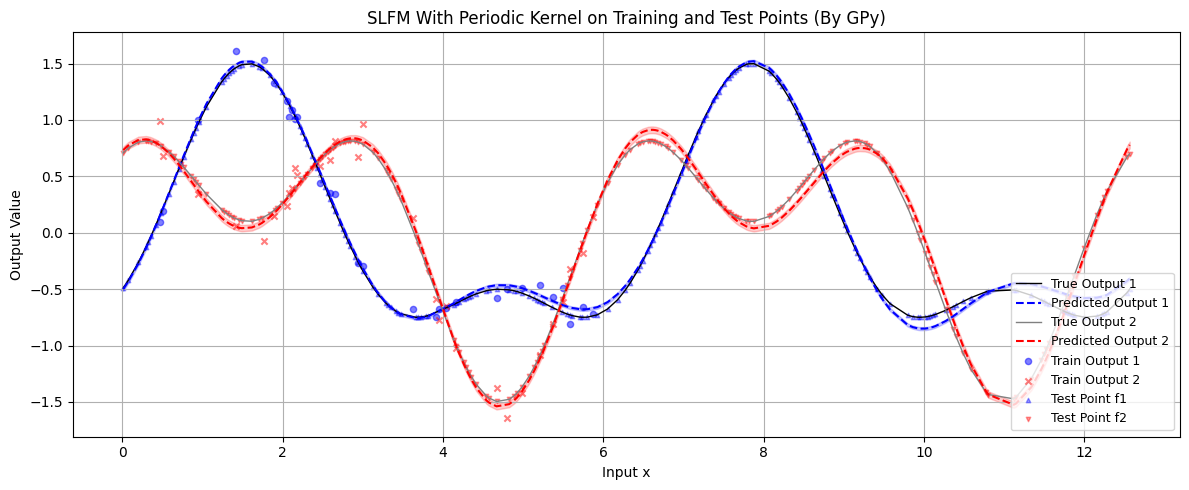

In [ ]:
# plot predictions and uncertainties with training and test points highlighted
fig, ax = plt.subplots(figsize=(12, 5))

X_train_flat = X_train.flatten()
X_test_flat = X_test.flatten()

# plot true and predicted for Output 1
ax.plot(X_test, y1_test, label="True Output 1", color="black", linewidth=1)
ax.plot(X_test, mu_0[:,0], label="Predicted Output 1", linestyle="--", color="blue")
ax.fill_between(X_test_flat,
                mu_0[:,0] - 2 * var_0[:,0],
                mu_0[:,0] + 2 * var_0[:,0],
                color="blue", alpha=0.2)

# plot true and predicted for Output 2
ax.plot(X_test, y2_test, label="True Output 2", color="gray", linewidth=1)
ax.plot(X_test, mu_1[:,0], label="Predicted Output 2", linestyle="--", color="red")
ax.fill_between(X_test_flat,
                mu_1[:,0] - 2 * var_1[:,0],
                mu_1[:,0] + 2 * var_1[:,0],
                color="red", alpha=0.2)

# training points
ax.scatter(X_train, y1_train, color="blue", s=20, label="Train Output 1", alpha=0.5, marker='o')
ax.scatter(X_train, y2_train, color="red", s=20, label="Train Output 2", alpha=0.5, marker='x')

# test points (without noise)
ax.scatter(X_test, y1_test, color="blue", s=10, label="Test Point f1", alpha=0.4, marker='^')
ax.scatter(X_test, y2_test, color="red", s=10, label="Test Point f2", alpha=0.4, marker='v')

# settings
ax.set_title("SLFM With Periodic Kernel on Training and Test Points (By GPy)")
ax.set_xlabel("Input x")
ax.set_ylabel("Output Value")
ax.legend(loc="lower right", fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()
